In [49]:
#General
import os
import pandas as pd
import math
import numpy as np
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import keras as k
from keras import backend as K

#Data
import wfdb
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
import scipy
from scipy.signal import butter, filtfilt, resample

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth=True
K.set_session(tf.compat.v1.Session(config = config))

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
#Find AAMI classes
def which_class(x):
    if np.isin(x,N): return 'N'
    elif np.isin(x,S): return 'S'
    elif np.isin(x,V): return 'V'
    elif np.isin(x,F): return 'F'
    else: return 'N'
    
#definition of AAMI classes
N = ['.','N','L','R','e','j','n'];
S = ['A','a','J','S'];
V = ['V','E','r'];
F = ['F'];

In [50]:
complete_data_mit = pd.DataFrame()

half_qrs = 210 #Single beat segmentation -> initial beat length: 420pt
pts = 320 #Triple beat segmentation -> beat length: 320pt
lead = []

#Beat selection from Physionet beats annotation guidlines
good_beats = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r','F', 'e', 'j', 'n', 'E']

for filename in os.listdir('mitdb'):
    if filename.endswith(".dat"):
        ann = wfdb.rdann('mitdb/' + filename.strip('.dat'), 'atr')
        record = wfdb.rdsamp('mitdb/' + filename.strip('.dat'))
        record_num = filename.strip('.dat')
        
        #Signals
        data = record[0]
        dictionary = record[1]
        #print(dictionary["sig_name"])
        lead.append(dictionary["sig_name"])
        
        signals1, signals2, classes, signals3 = [], [], [], []
        
        #Beat extraction
        for it, beat in enumerate(ann.symbol):
            if it>0:
                if beat in good_beats:
                    
                    #Single beat extraction
                    sta1 = ann.sample[it] - half_qrs
                    end1 = ann.sample[it] + half_qrs
                    qrs1 = data[sta1 : end1, :]
                    
                    #Triple beat extraction
                    sta2 = math.floor((ann.sample[it] + ann.sample[it-1])/2)
                    end2 = sta2 + pts
                    qrs2 = data[sta2 : end2, :]
                    
                    #Avoid problems at the edges
                    if len(qrs1) != 2 * half_qrs: continue
                    if end2 > len(data[:,0]): continue

                    curr_beat1 = qrs1.reshape(half_qrs*2,2)
                    curr_beat2 = qrs2.reshape(pts,2)
                    signals1.append(curr_beat1)
                    signals2.append(curr_beat2)
                    classes.append(beat)

        for i in range(1,len(signals2)-1):
            temp = np.hstack((signals2[i-1],signals2[i],signals2[i+1]))
            signals3.append(temp)
            temp=0
            
        #Single and triple beat consistency
        signals1.pop(0)
        signals1.pop(-1)
        classes.pop(0)
        classes.pop(-1)
        
        
        #Obtained data 
        frame = pd.DataFrame({'beat' : signals1,
                              '3beat' : signals3,
                              'label' : classes,
                              'record' : record_num})

        complete_data_mit = complete_data_mit.append(frame)

In [51]:
complete_data_st = pd.DataFrame()

half_qrs = 210 #Single beat segmentation -> initial beat length: 420pt
pts = 320 #Triple beat segmentation -> beat length: 320pt
count = 0
maximum = 75
database = 'incartdb'
sampling_rate = 257
lead = []
# Define the cutoff frequency
cutoff_freq = 100  # Hz
# Define the filter order
filter_order = 4
# Calculate the normalized cutoff frequency
nyquist_freq = 0.5 * 360  # The Nyquist frequency is half the sampling rate
normalized_cutoff_freq = cutoff_freq / nyquist_freq
# Define the number of samples to use for padding
padlen = 3
#Beat selection from Physionet beats annotation guidlines
good_beats = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r','F', 'e', 'j', 'n', 'E']

for filename in os.listdir(database):
    if count < maximum:
        if filename.endswith(".dat"):
            ann = wfdb.rdann(database + '/' + filename.strip('.dat'), 'atr')
            record = wfdb.rdsamp(database + '/' + filename.strip('.dat'))
            record_num = filename.strip('.dat')
            
            #Signals
            data = record[0]
            info = record[1]
            lead = info["sig_name"]
            resampling_factor = 360 / sampling_rate
            resampled_signal = scipy.signal.resample(data, int(len(data) * resampling_factor))

            # Design the filter coefficients
            b, a = butter(filter_order, normalized_cutoff_freq, btype='lowpass')

            # Apply the filter to the resampled ECG signal
            filtered_signal = filtfilt(b, a, resampled_signal, padlen=padlen)

            signals1, signals2, classes, signals3 = [], [], [], []

            data = filtered_signal[:,[1,6]]
            #data = data[:,[1,6]]

            #Beat extraction
            for it, beat in enumerate(ann.symbol):
                if it>0:
                    if beat in good_beats:
                        
                        new_annotation = int(ann.sample[it] * (360 / sampling_rate))
                        new_annotation_prev = int(ann.sample[it-1] * (360 / sampling_rate))
                        
                        #Single beat extraction
                        sta1 = new_annotation - half_qrs
                        end1 = new_annotation + half_qrs
                        qrs1 = data[sta1 : end1, :]

                        
                        #Triple beat extraction
                        sta2 = math.floor((new_annotation + new_annotation_prev)/2)
                        end2 = sta2 + pts
                        qrs2 = data[sta2 : end2, :]
                        
                        #Avoid problems at the edges
                        if len(qrs1) != 2 * half_qrs: continue
                        if end2 > len(data[:,0]): continue

                        curr_beat1 = qrs1.reshape(half_qrs*2,2)
                        curr_beat2 = qrs2.reshape(pts,2)
                        signals1.append(curr_beat1)
                        signals2.append(curr_beat2)
                        classes.append(beat)

            #Triple beat arrangement
            for i in range(1,len(signals2)-1):
                temp = np.hstack((signals2[i-1],signals2[i],signals2[i+1]))
                signals3.append(temp)
                temp=0
                
            #Single and triple beat consistency
            signals1.pop(0)
            signals1.pop(-1)
            classes.pop(0)
            classes.pop(-1)
            
            
            #Obtained data 
            frame = pd.DataFrame({'beat' : signals1,
                                '3beat' : signals3,
                                'label' : classes,
                                'record' : record_num})

            complete_data_st = complete_data_st.append(frame)
            count = count + 1

In [52]:
x = complete_data_st[complete_data_st["label"].isin(["F"])]

records, amount = np.unique(x["record"],return_counts = True)

sorted_indices = np.argsort(amount)[::-1]  # Get the indices that would sort array2 in descending order
list_patients_st_f = list(records[sorted_indices])


In [53]:
list_patients_mit = ['101', '106', '108', '109',
                     '112', '115', '116', '118', 
                     '119', '122', '201', '203', 
                     '205', '207', '208', '209', 
                     '215', '220', '223', '230']
ratio = "2:1"
if ratio == "2:1":
    train_patients_mit = random.sample(list_patients_mit, 14)
    train_patients_st = list_patients_st_f[0:6]
if ratio == "1:1":
    train_patients_mit = random.sample(list_patients_mit, 10)
    train_patients_st = list_patients_st_f[0:9]
if ratio == "1:2":
    train_patients_mit = random.sample(list_patients_mit, 7)
    train_patients_st = list_patients_st_f[0:13]
    

mask = np.isin(complete_data_mit['record'], train_patients_mit)
train_df_mit = complete_data_mit[mask]

mask = np.isin(complete_data_st['record'], train_patients_st)
train_df_st = complete_data_st[mask]

##########################################################################################################################################################################################################

mask = np.isin(complete_data_mit['record'],['100', '105', '111', '113', '121',
                                           '200', '202', '210', '212', '213', 
                                           '214', '219', '221', '222', '228', 
                                           '231', '232', '233', '234'])


test_df_mit = complete_data_mit[mask]


mask = np.isin(complete_data_st['record'], ['I02', 'I03', 'I04', 'I05', 
                                            'I11', 'I12', 'I24', 'I25',
                                            'I20', 'I50', 'I33', 'I39', 'I44',
                                            'I64', 'I66', 'I67', 'I68',
                                            'I73', 'I56'])

test_df_st = complete_data_st[mask]

In [54]:
display(train_df_mit)

,beat,3beat,label,record
0,"[[-0.2, 0.51], [-0.185, 0.535], [-0.195, 0.525...","[[-0.125, 0.29, -0.175, 0.8, -0.195, 0.45], [-...",N,215
1,"[[-0.285, 0.655], [-0.26, 0.645], [-0.18, 0.65...","[[-0.175, 0.8, -0.195, 0.45, -0.245, 0.215], [...",N,215
2,"[[-0.235, 0.3], [-0.265, 0.3], [-0.3, 0.3], [-...","[[-0.195, 0.45, -0.245, 0.215, -0.235, 0.095],...",N,215
3,"[[-0.25, 0.185], [-0.255, 0.185], [-0.29, 0.16...","[[-0.245, 0.215, -0.235, 0.095, -0.215, 0.125]...",N,215
4,"[[-0.26, 0.09], [-0.245, 0.08], [-0.275, 0.09]...","[[-0.235, 0.095, -0.215, 0.125, -0.2, 0.14], [...",N,215
...,...,...,...,...
1851,"[[-0.165, -0.03], [-0.17, -0.04], [-0.185, -0....","[[0.075, 0.015, 0.095, 0.115, 0.05, 0.095], [0...",A,207
1852,"[[-0.185, -0.035], [-0.19, -0.025], [-0.19, -0...","[[0.095, 0.115, 0.05, 0.095, -0.075, -0.015], ...",A,207
1853,"[[-0.255, -0.045], [-0.245, -0.035], [-0.25, -...","[[0.05, 0.095, -0.075, -0.015, -0.005, 0.055],...",A,207
1854,"[[-0.28, -0.1], [-0.27, -0.095], [-0.285, -0.1...","[[-0.075, -0.015, -0.005, 0.055, 0.14, 0.145],...",A,207


In [21]:
display(train_df_st)

,beat,3beat,label,record
0,"[[3.442140383705655, 2.8587977200018946], [3.4...","[[3.93589660097776, 3.2464339730046285, 3.4748...",N,I42
1,"[[3.7026198509282566, 2.88701930154371], [3.70...","[[3.474828777039166, 2.820813103926503, 4.0165...",V,I42
2,"[[3.4014609907826756, 2.8630880891273507], [3....","[[4.0165645641720795, 3.316757927560971, 3.453...",N,I42
3,"[[3.698086998952606, 2.901227141480961], [3.70...","[[3.453989528212603, 2.8409527881656778, 3.943...",V,I42
4,"[[3.398314030515611, 2.876742789386323], [3.39...","[[3.943309437155994, 3.291538121717891, 3.4283...",N,I42
...,...,...,...,...
3667,"[[-10.780665162496671, -3.7285625052547866], [...","[[-10.850370276570889, -3.5568546753962647, -1...",N,I35
3668,"[[-10.741081200431138, -3.78410620947196], [-1...","[[-10.922623676391096, -3.6057362967143094, -1...",N,I35
3669,"[[-10.300390326884651, -3.8118871446045235], [...","[[-10.698357778939233, -3.7296977933987203, -1...",N,I35
3670,"[[-9.422222224236425, -3.7661038370595956], [-...","[[-10.00423998247975, -3.760261831631353, -9.0...",N,I35


In [22]:
#Single beat
df = test_df_st
test = df['beat'].values
testX_1beat_st = np.vstack(test).reshape(test.shape[0],half_qrs*2,2)
    
mean_vals = np.mean(testX_1beat_st, axis=1)[:, np.newaxis]  # shape (n_samples, 1)
testX_1beat_st = testX_1beat_st - mean_vals
    
#Triple beat
beats_3 = df['3beat'].values
testX_3beat_st = np.vstack(beats_3).reshape(beats_3.shape[0],pts,6) #

mean_vals = np.mean(testX_3beat_st, axis=1)[:, np.newaxis]  # shape (n_samples, 1)
testX_3beat_st = testX_3beat_st - mean_vals 

#MIT annotations
labels_st = test_df_st['label'].values
testY_lbl_st = np.array([which_class(x) for x in labels_st])


#Single beat
df = train_df_st
train = df['beat'].values
trainX_1beat_st = np.vstack(train).reshape(train.shape[0],half_qrs*2,2)
    
mean_vals = np.mean(trainX_1beat_st, axis=1)[:, np.newaxis]  # shape (n_samples, 1)
trainX_1beat_st = trainX_1beat_st - mean_vals
    
#Triple beat
beats_3 = df['3beat'].values
trainX_3beat_st = np.vstack(beats_3).reshape(beats_3.shape[0],pts,6) #

mean_vals = np.mean(trainX_3beat_st, axis=1)[:, np.newaxis]  # shape (n_samples, 1)
trainX_3beat_st = trainX_3beat_st - mean_vals 

#MIT annotations
labels_st = train_df_st['label'].values
trainY_lbl_st = np.array([which_class(x) for x in labels_st])


In [51]:
#Single beat
df = test_df_mit
test = df['beat'].values
testX_1beat_mit = np.vstack(test).reshape(test.shape[0],half_qrs*2,2)
    
#Triple beat
beats_3 = df['3beat'].values
testX_3beat_mit = np.vstack(beats_3).reshape(beats_3.shape[0],pts,6) #

#MIT annotations
labels_mit = test_df_mit['label'].values
testY_lbl_mit = np.array([which_class(x) for x in labels_mit])

#Single beat
df = train_df_mit
#eliminate S and e classes, which are not included in the test set
df = df[np.isin(df['label'],['S','e'], invert = True)]

train = df['beat'].values
trainX_1beat_mit = np.vstack(train).reshape(train.shape[0],half_qrs*2,2)
    
    
#Triple beat
beats_3 = df['3beat'].values
trainX_3beat_mit = np.vstack(beats_3).reshape(beats_3.shape[0],pts,6) #

#MIT annotations
labels_mit = df['label'].values
trainY_lbl_mit = np.array([which_class(x) for x in labels_mit])

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(trainY_lbl_mit)

trainY_int_mit = label_encoder.transform(trainY_lbl_mit)
trainY_oh_mit = to_categorical(trainY_int_mit)

trainY_int_st = label_encoder.transform(trainY_lbl_st)
trainY_oh_st = to_categorical(trainY_int_st)

testY_int_mit = label_encoder.transform(testY_lbl_mit)
testY_oh_mit = to_categorical(testY_int_mit)

testY_int_st = label_encoder.transform(testY_lbl_st)
testY_oh_st = to_categorical(testY_int_st)

Text(0.5, 0.98, 'Heartbeats for each of the conditions, offset corrected')

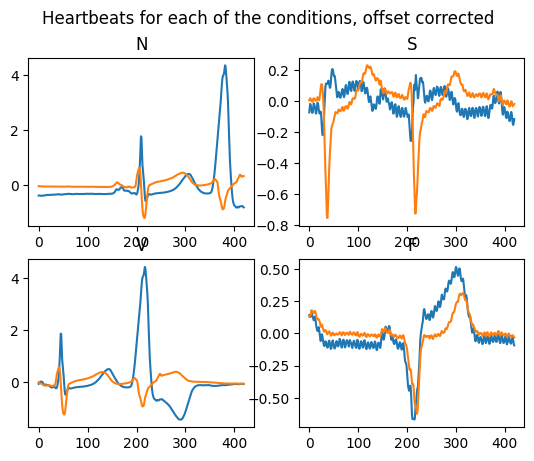

In [24]:
N = np.where(trainY_lbl_st  == 'N')[0][20]
S = np.where(trainY_lbl_st  == 'S')[0][20]
V = np.where(trainY_lbl_st  == 'V')[0][20]
F = np.where(trainY_lbl_st  == 'F')[0][20]

fig, axes = plt.subplots(nrows=2, ncols=2)

# Plot the data on the four subplots
axes[0, 0].plot(trainX_1beat_st[N])
axes[0, 0].set_title('N')
axes[0, 1].plot(trainX_1beat_st[S])
axes[0, 1].set_title('S')
axes[1, 0].plot(trainX_1beat_st[V])
axes[1, 0].set_title('V')
axes[1, 1].plot(trainX_1beat_st[F])
axes[1, 1].set_title('F')

# Set the title of the entire figure
fig.suptitle('Heartbeats for each of the conditions, offset corrected')
# Show the plots

In [ ]:

def balancing_dataset(X, Y_lbl, Y_int, Y_oh):
    
    N_indeces = np.argwhere('N' == Y_lbl).reshape(1,-1)[0,:]
    balanced_X = X[N_indeces]
    balanced_Y_lbl = Y_lbl[N_indeces]
    balanced_Y_int = Y_int[N_indeces]
    balanced_Y_oh = Y_oh[N_indeces]
    
    N = len(N_indeces)
    
    for lbl in np.unique(Y_lbl):
        i = np.argwhere(lbl == Y_lbl).reshape(1,-1)[0,:]
        
        if lbl=='N':
            x = 1
        else:
            x = math.floor(2*N/len(i))

        a = np.vstack([X[i]]*x)
        balanced_X = np.vstack((balanced_X, a))
        a = np.hstack([Y_lbl[i]]*x)
        balanced_Y_lbl = np.hstack((balanced_Y_lbl, a))
        a = np.hstack([Y_int[i]]*x)
        balanced_Y_int = np.hstack((balanced_Y_int, a))
        a = np.vstack([Y_oh[i]]*x)
        balanced_Y_oh = np.vstack((balanced_Y_oh, a))
        
    return balanced_X, balanced_Y_lbl, balanced_Y_int, balanced_Y_oh

In [ ]:
#Test set peak-shifting
test_1beat_mit = np.zeros((testX_1beat_mit.shape[0], 320, 2))

for i in range(testX_1beat_mit.shape[0]):
    sta = np.random.choice(range(0,101))
    end = sta + 320
    test_1beat_mit[i,:,:] = testX_1beat_mit[i, sta:end, :]
    
test_1beat_st = np.zeros((testX_1beat_st.shape[0], 320, 2))

for i in range(test_1beat_st.shape[0]):
    sta = np.random.choice(range(0,101))
    end = sta + 320
    test_1beat_st[i,:,:] = testX_1beat_st[i, sta:end, :]

In [11]:
#SINGLE-BEAT SEGMENTATION -> BALANCING AND PEAK SHIFTING

#Train set balancing
bal_train_3beat_st, bal_train_lbl_st, bal_train_int_st, bal_train_oh_st = balancing_dataset(trainX_3beat_st, trainY_lbl_st, trainY_int_st, trainY_oh_st)
bal_train_1beat_st, bal_train_lbl_st, bal_train_int_st, bal_train_oh_st = balancing_dataset(trainX_1beat_st, trainY_lbl_st, trainY_int_st, trainY_oh_st)

#Train set balancing
bal_train_3beat_mit, bal_train_lbl_mit, bal_train_int_mit, bal_train_oh_mit = balancing_dataset(trainX_3beat_mit, trainY_lbl_mit, trainY_int_mit, trainY_oh_mit)
bal_train_1beat_mit, bal_train_lbl_mit, bal_train_int_mit, bal_train_oh_mit = balancing_dataset(trainX_1beat_mit, trainY_lbl_mit, trainY_int_mit, trainY_oh_mit)


In [12]:

#Train set peak-shifting
bal_trainX_1beat_mit = np.zeros((bal_train_1beat_mit.shape[0], 320, 2))

for i in range(bal_trainX_1beat_mit.shape[0]):
    sta = np.random.choice(range(0,101))
    end = sta + 320
    bal_trainX_1beat_mit[i,:,:] = bal_train_1beat_mit[i, sta:end, :]
    
bal_trainX_1beat_st = np.zeros((bal_train_1beat_st.shape[0], 320, 2))

for i in range(bal_trainX_1beat_st.shape[0]):
    sta = np.random.choice(range(0,101))
    end = sta + 320
    bal_trainX_1beat_st[i,:,:] = bal_train_1beat_st[i, sta:end, :]


In [13]:
bal_train_1beat_final = np.concatenate((bal_trainX_1beat_mit, bal_trainX_1beat_st), axis=0)
bal_train_3beat_final = np.concatenate((bal_train_3beat_mit, bal_train_3beat_st), axis=0)
bal_train_lbl_final = np.concatenate((bal_train_lbl_mit, bal_train_lbl_st), axis=0)
bal_train_int_final = np.concatenate((bal_train_int_mit, bal_train_int_st), axis=0)
bal_train_oh_final = np.concatenate((bal_train_oh_mit, bal_train_oh_st), axis=0)

In [14]:
    
test_1beat_final = np.concatenate((test_1beat_mit, test_1beat_st), axis=0)
test_3beat_final = np.concatenate((testX_3beat_mit, testX_3beat_st), axis=0)
test_lbl_final = np.concatenate((testY_lbl_mit, testY_lbl_st), axis=0)
test_int_final = np.concatenate((testY_int_mit, testY_int_st), axis=0)
test_oh_final = np.concatenate((testY_oh_mit, testY_oh_st), axis=0)

    
#test_1beat_final = test_1beat_st
#test_3beat_final = testX_3beat_st
#test_lbl_final = testY_lbl_st
#test_int_final = testY_int_st
#test_oh_final = testY_oh_st

(320554, 320, 2)